In [54]:
import warnings
warnings.filterwarnings('ignore')

import os 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy  as np
from tqdm import tqdm 
import time

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, 'Dataset')
os.listdir(data_dir)

['test_data_unscaled.csv',
 'dataset_here',
 'train_data_unscaled.csv',
 'household_power_consumption.txt',
 'y_train.npy',
 'y_test.npy',
 'X_test.npy',
 'electricity_data_resampled.csv',
 'X_train.npy']

In [3]:
train_data = pd.read_csv(os.path.join(data_dir, 'train_data_unscaled.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test_data_unscaled.csv'))

In [4]:
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

train_data.set_index('DateTime', inplace=True)
test_data.set_index('DateTime', inplace=True)

In [5]:
print(f"Train Data Size : {train_data.shape[0]}")
print(f"Test Data Size : {test_data.shape[0]}")

Train Data Size : 1001
Test Data Size : 434


In [6]:
train_data.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_rem
DateTime,,,,,,,,
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375


In [67]:
def fit_arima_model(train_data, order):
    """
    Fits an ARIMA model to the training data.
    
    Parameters:
    - train_data: The training time series data.
    - order: A tuple (p, d, q) for the ARIMA model.
    
    Returns:
    - Fitted ARIMA model.
    """
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

def predict_and_update(model_fit, actual_value, steps=1, refit=False):
    """
    Uses the fitted ARIMA model to predict the next time step and updates the model with the actual value.
    
    Parameters:
    - model_fit: The fitted ARIMA model.
    - actual_value: The actual observed value to update the model.
    
    Returns:
    - The predicted next value.
    - The updated model fit.
    """
    forecast = model_fit.forecast(steps=steps)
    # Update the model with the actual value
    updated_model_fit = model_fit.append([actual_value], refit=refit)
    return forecast[0], updated_model_fit

def evaluate_forecast(actual, predicted):
    """
    Calculates the Mean Squared Error between actual and predicted values.
    
    Parameters:
    - actual: Array of actual values.
    - predicted: Array of predicted values.
    
    Returns:
    - The MSE score.
    """
    mse = mean_squared_error(actual, predicted)
    return mse

def evaluate_models(train_data, p_values, d_values, q_values):
    """
    Evaluates ARIMA models with different combinations of p, d, and q values on the training data.
    
    Parameters:
    - train_data: The training time series data.
    - p_values: List of values to consider for the AR order.
    - d_values: List of values to consider for the degree of differencing.
    - q_values: List of values to consider for the MA order.
    
    Returns:
    - A tuple (best_order, best_model_bic) containing the best model order and its BIC.
    """
    best_bic = np.inf
    best_order = None
    best_model = None

    data = train_data.copy()
    data.index = data.index.to_period('D')
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(data, order=order)
                    model_fit = model.fit()
                    bic = model_fit.bic
                    print(f"Order : {order} BIC: {bic}")
                    if bic < best_bic:
                        best_bic = bic
                        best_order = order
                        best_model = model_fit
                except Exception as e:
                    print(e)
                    continue

    return best_order, best_bic

### We will be using ACF and PACF plots along with AIC/BIC criteria to select best model paramters

In [26]:
PRIMARY_TIME_SERIES = 'Global_active_power'

In [27]:
def plot_correlation_plots(data , col_name, lags):
    # Plot ACF plot
    plot_acf(data[col_name], lags=lags, title=col_name)  
    plt.show()
    
    # Plot the Partial Autocorrelation Function (PACF)
    plot_pacf(data[col_name], lags=lags, title=col_name)
    plt.show()

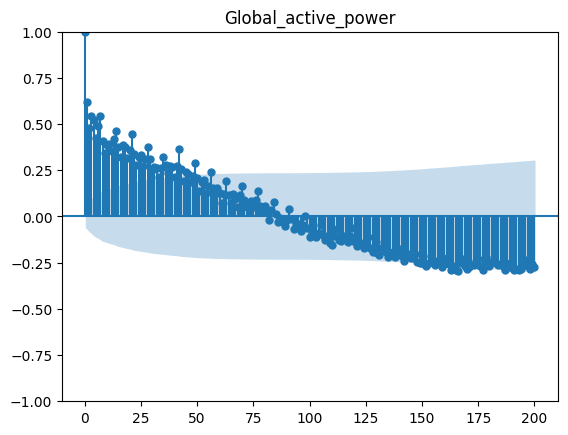

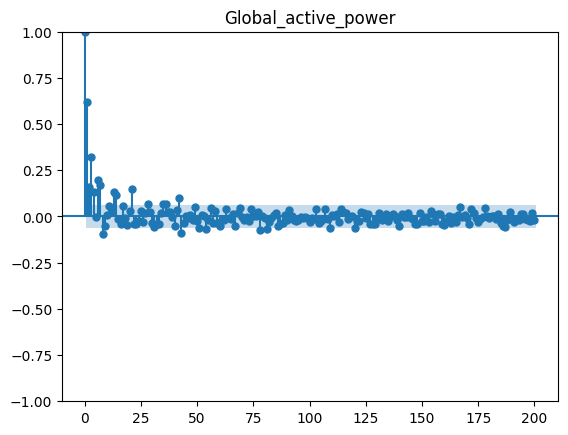

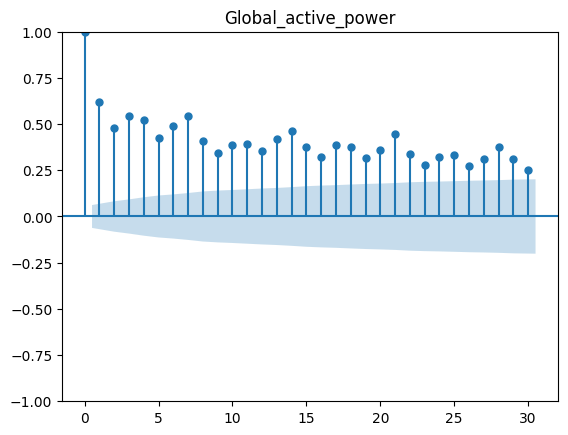

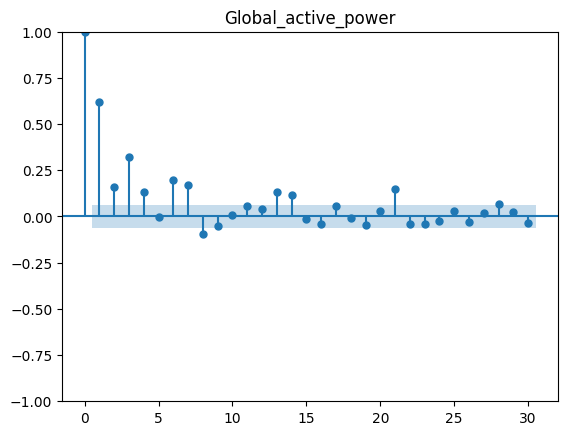

In [28]:
plot_correlation_plots(data=train_data , col_name=PRIMARY_TIME_SERIES, lags=200)
plot_correlation_plots(data=train_data , col_name=PRIMARY_TIME_SERIES, lags=30)

**Analysis**

For AR parameter : The correlations seems to fade out after 9-10 time steps. So, we will select a window of (0, 10) to get the best lag estimate

In [37]:
train_df = train_data[PRIMARY_TIME_SERIES]
test_df = test_data[PRIMARY_TIME_SERIES]

## AR Model

In [ ]:
p_values = range(0,11)
q_values = [0]
d_values = [0]

best_order, best_bic = evaluate_models(train_df, p_values, d_values, q_values)
print(f"Best Order: {best_order}, Best BIC: {best_bic}")

# Fit and evaluate the final best model 
ar_model = fit_arima_model(train_df, order=best_order)
ar_model.summary()

REFIT MODEL = False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:08<00:00, 49.83it/s]


AR Model MSE: 0.06089170365639489
Evaluation Time : 8.71852970123291s


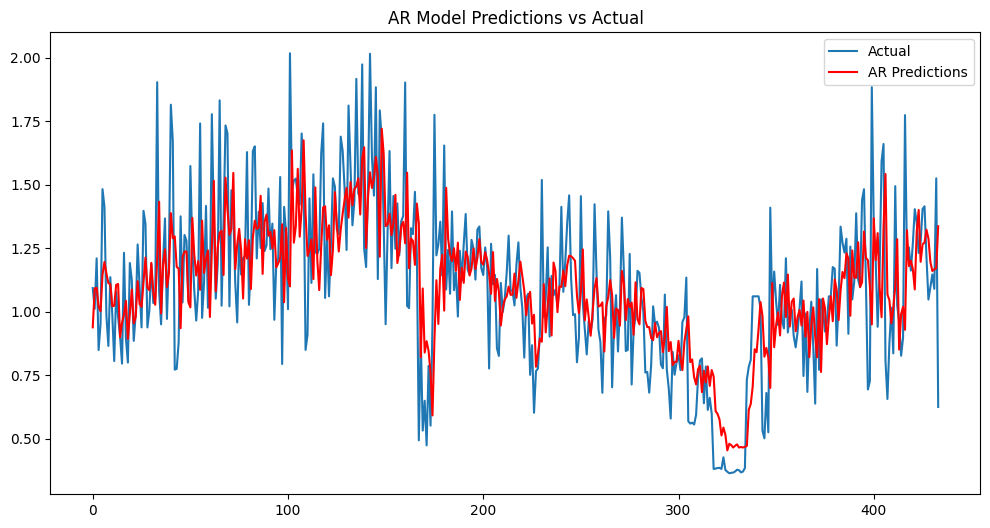

REFIT MODEL = True


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [04:42<00:00,  1.54it/s]


AR Model MSE: 0.0608869668974947
Evaluation Time : 282.71699690818787s


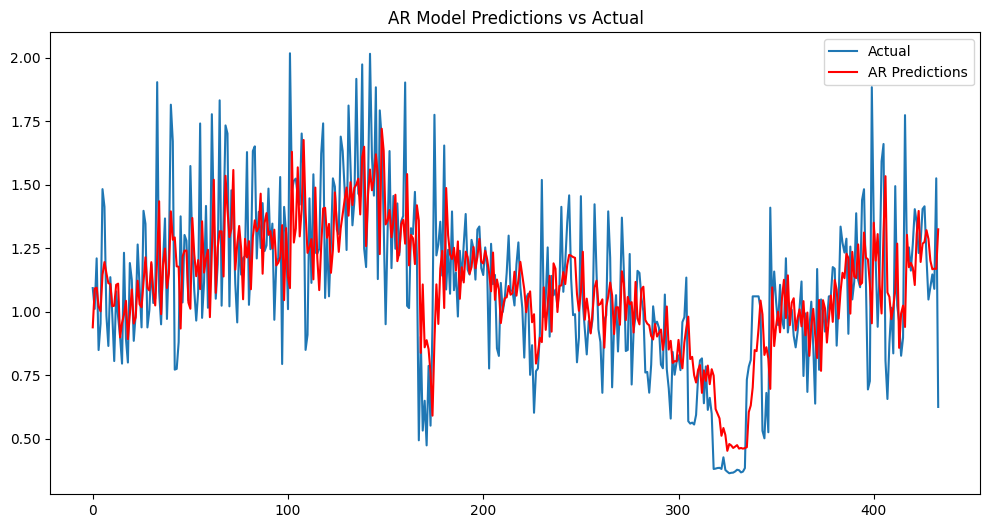

In [57]:
## UPDATE THE MODEL WITH REFIT 
for refit in (False, True):
    test_predictions = []
    model = fit_arima_model(train_df, order=best_order)
    print(f"REFIT MODEL = {refit}")
    start = time.time()
    for actual_value in tqdm(test_df.values):
        # Predict the next step and update the model with the actual value
        forecast, model = predict_and_update(model, actual_value, refit=refit)
        test_predictions.append(forecast)
    mse = evaluate_forecast(test_df.values, test_predictions)
    print(f'AR Model MSE: {mse}')
    end = time.time()
    print(f"Evaluation Time : {end-start}s")

    # Plotting the predictions for visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test_df.values, label='Actual')
    plt.plot(test_predictions, label='AR Predictions', color='red')
    plt.legend()
    plt.title('AR Model Predictions vs Actual')
    plt.show()

**Conclusions and Takeaways**

- From the BIC Evaluation criteria, the best_order to be found is (8,0,0) which means 8 lags for AR model. This also matches our interpretation from the PCF Plots
- From the fitted model summary, all the coefficients of previous time steps have p-values less than 5% except L2.
- Without refitting the model again with the predictions yields a MSE of 0.06 while refitting also yields on the same line. But refitting the model again is very slow (282s vs 8s). Hence, we will select the model without refitting
- From the Plot of Actual vs Predicted, it can be observed that the predictions are able to follow the trend of the ground truth but not able to match their level. Hence, MA will be a next step to explore and also their combination. 


## MA Model 

In [61]:
p_values = [0]
q_values = range(0,25)
d_values = [0]

ma_best_order, ma_best_bic = evaluate_models(train_df, p_values, d_values, q_values)
print(f"Best Order: {ma_best_order}, Best BIC: {ma_best_bic}")

# Fit and evaluate the final best model 
ma_model = fit_arima_model(train_df, order=ma_best_order)
ma_model.summary()

Best Order: (0, 0, 21), Best BIC: 626.6493885985117


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                 1001
Model:                 ARIMA(0, 0, 21)   Log Likelihood                -233.874
Date:                 Thu, 22 Feb 2024   AIC                            513.748
Time:                         14:44:28   BIC                            626.649
Sample:                     12-18-2006   HQIC                           556.656
                          - 09-13-2009                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0879      0.049     22.340      0.000       0.992       1.183
ma.L1          0.3873      0.025     15.221      0.000       0.337       0.437
ma.L2          0.1774      0.030      5.950      0.000       0.119       0.236
ma.L3          0.2856      0.031      9.248      0.000       0.225       0.346
ma.L4          0.2888      0.029      9.980      0.000       0.232       0.346
ma.L5          0.1485      0.034      4.338      0.000       0.081       0.216
ma.L6          0.2506      0.033      7.686      0.000       0.187       0.315
ma.L7          0.3447      0.034     10.142      0.000       0.278       0.411
ma.L8          0.1233      0.033      3.789      0.000       0.060       0.187
ma.L9          0.0625      0.033      1.872      0.061      -0.003       0.128
ma.L10         0.0838      0.032      2.629      0.009       0.021       0.146
ma.L11         0.0856      0.033      2.565      0.010       0.020       0.151
ma.L12         0.0718      0.033      2.189      0.029       0.008       0.136
ma.L13         0.1703      0.036      4.784      0.000       0.101       0.240
ma.L14         0.2342      0.032      7.419      0.000       0.172       0.296
ma.L15         0.1197      0.032      3.720      0.000       0.057       0.183
ma.L16         0.0308      0.036      0.857      0.392      -0.040       0.101
ma.L17         0.1501      0.034      4.398      0.000       0.083       0.217
ma.L18         0.1517      0.033      4.575      0.000       0.087       0.217
ma.L19         0.0715      0.036      2.008      0.045       0.002       0.141
ma.L20         0.1378      0.032      4.242      0.000       0.074       0.202
ma.L21         0.2204      0.026      8.333      0.000       0.169       0.272
sigma2         0.0932      0.003     27.328      0.000       0.087       0.100
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               251.62
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Fitting Model : (0, 0, 21)
REFIT MODEL = False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:27<00:00, 15.80it/s]


MA Model MSE: 0.06339678239330217
Evaluation Time : 27.608211994171143s


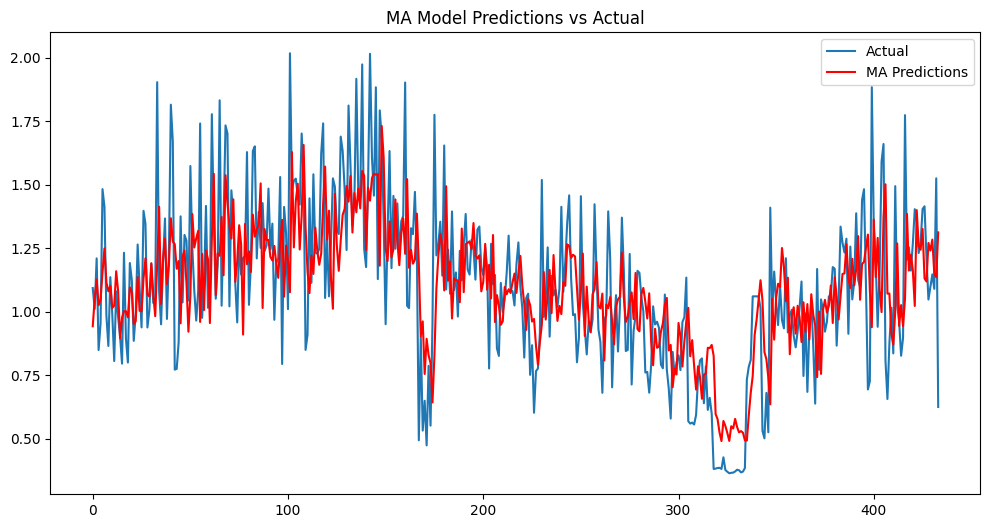

In [64]:
## UPDATE THE MODEL WITH REFIT 
for refit in (False,):
    test_predictions = []
    print(f"Fitting Model : {ma_best_order}")
    model = fit_arima_model(train_df, order=ma_best_order)
    print(f"REFIT MODEL = {refit}")
    start = time.time()
    for actual_value in tqdm(test_df.values):
        # Predict the next step and update the model with the actual value
        forecast, model = predict_and_update(model, actual_value, refit=refit)
        test_predictions.append(forecast)
    mse = evaluate_forecast(test_df.values, test_predictions)
    print(f'MA Model MSE: {mse}')
    end = time.time()
    print(f"Evaluation Time : {end-start}s")

    # Plotting the predictions for visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test_df.values, label='Actual')
    plt.plot(test_predictions, label='MA Predictions', color='red')
    plt.legend()
    plt.title('MA Model Predictions vs Actual')
    plt.show()

**Conclusions and Insights**

- TODO

In [68]:
## ARIMA Model 

p_values = range(5,10)
q_values = range(15,23)
d_values = range(0,4)

arima_best_order, arima_best_bic = evaluate_models(train_df, p_values, d_values, q_values)
print(f"Best Order: {arima_best_order}, Best BIC: {arima_best_bic}")

# Fit and evaluate the final best model 
arima_model = fit_arima_model(train_df, order=arima_best_order)
arima_model.summary()

Order : (5, 0, 15) BIC: 593.7959241368512
Order : (5, 0, 16) BIC: 597.6581631107581
Order : (5, 0, 17) BIC: 601.444008275819
Order : (5, 0, 18) BIC: 602.0961038406256
Order : (5, 0, 19) BIC: 608.5527536060199
Order : (5, 0, 20) BIC: 605.728138743523
Order : (5, 0, 21) BIC: 639.075125577031
Order : (5, 0, 22) BIC: 638.1186622386988
Order : (5, 1, 15) BIC: 547.0527426878184
Order : (5, 1, 16) BIC: 552.6509697357627
Order : (5, 1, 17) BIC: 560.7966250131029
Order : (5, 1, 18) BIC: 563.9296397460744
Order : (5, 1, 19) BIC: 575.0100528845221
Order : (5, 1, 20) BIC: 580.7736345330793
Order : (5, 1, 21) BIC: 586.3139261438203
Order : (5, 1, 22) BIC: 595.9037940054703
Order : (5, 2, 15) BIC: 620.3344608669174
Order : (5, 2, 16) BIC: 626.5324115629785
Order : (5, 2, 17) BIC: 631.8588001572905
Order : (5, 2, 18) BIC: 638.6813139016858
Order : (5, 2, 19) BIC: 644.453880236696
Order : (5, 2, 20) BIC: 651.8415011899078
Order : (5, 2, 21) BIC: 655.3485902226333
Order : (5, 2, 22) BIC: 660.7721667697

KeyboardInterrupt: 

In [ ]:
# Fit and evaluate the final best model 
arima_model = fit_arima_model(train_df, order=arima_best_order)
arima_model.summary()